In [176]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import TweetTokenizer

from collections import Counter

import re

# Analyse général de la structure du dataset

In [159]:
df_path= "../../scitweets.tsv"
df = pd.read_csv(df_path, sep='\t', header=0)

df = df.drop(columns=[col for col in df.columns if "Unnamed" in col] + ["tweet_id"])
df["text"] = df["text"].astype("string")

# Display basic information about the dataset
print(f"Dataset dimensions: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nDataset information:\n")
print(df.info())
display(df.head(1))

print("\nSummary statistics:")
display(df.describe())

Dataset dimensions: 1140 rows, 5 columns

Dataset information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text                  1140 non-null   string 
 1   science_related       1140 non-null   int64  
 2   scientific_claim      1140 non-null   float64
 3   scientific_reference  1140 non-null   float64
 4   scientific_context    1140 non-null   float64
dtypes: float64(3), int64(1), string(1)
memory usage: 44.7 KB
None


,text,science_related,scientific_claim,scientific_reference,scientific_context
0,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0



Summary statistics:


,science_related,scientific_claim,scientific_reference,scientific_context
count,1140.000000,1140.000000,1140.00000,1140.000000
mean,0.328947,0.230702,0.17807,0.220175
std,0.470037,0.421467,0.38274,0.414547
min,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.00000,0.000000
50%,0.000000,0.000000,0.00000,0.000000
75%,1.000000,0.000000,0.00000,0.000000
max,1.000000,1.000000,1.00000,1.000000


- On comprends déja qu'il y a 1140 tweets avec la présence de multiple labels (science_related, scientific_claim, scientific_reference,scientific_context)
- il n'y as pas de missing values (d'après le dataset information).
- 33% sont des tweets sciences related

<AxesSubplot:>

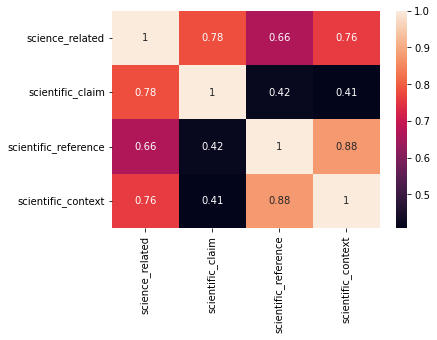

In [160]:
class_corr = df.select_dtypes(include='number').corr()

sns.heatmap(class_corr, annot=True)

on cherchant une corrélation entre les labels, on se rend compte de plusieurs choses :
- Premièrement, comme on se l'attendait, il y a une corrélation forte de `science_related` <-> (`scientific_claim`(78%) et `scientific_context`(76%))
- On se rend compte que la corrélation moyenne entre  `science_related` <-> `scientific_reference`
- Et surtout, qu'il existe une corrélation entre claim, reference et context. Donc un tweet peut être catégoriser dans plusieurs type de tweet scientifique!

Et avec cette découverte, on remarque une correlation forte entre `scientific_context` et `scientific_reference` (88%)
et une correlation moyennes entre `scientific_claim` <-> `scientific_context` (41%) et`scientific_claim` <-> `scientific_reference` (42%).

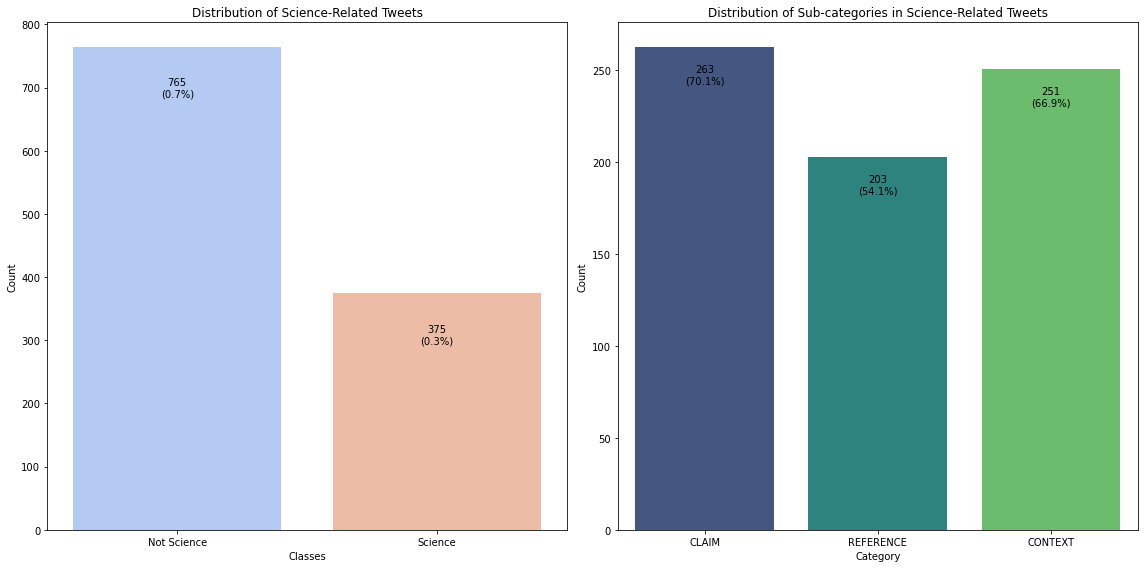

In [161]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
ax = sns.countplot(x="science_related", data=df, palette="coolwarm")
percentage =  df.describe()["science_related"]["mean"]
count = df.shape[0]
ax.text(0, count * (1 - percentage) - 80, f"{int(count * (1 - percentage))}\n({(1 - percentage):.1f}%)", ha='center')
ax.text(1, count * percentage - 80, f"{int(count * percentage)}\n({percentage:.1f}%)", ha='center')

ax.set_xticks([0, 1])
ax.set_xticklabels(["Not Science", "Science"])

plt.title("Distribution of Science-Related Tweets")
plt.xlabel("Classes")
plt.ylabel("Count")


sci_tweets = df[df['science_related'] == 1].copy()
subclass_counts = {
    'CLAIM': sci_tweets['scientific_claim'].sum(),
    'REFERENCE': sci_tweets['scientific_reference'].sum(),
    'CONTEXT': sci_tweets['scientific_context'].sum()
}

categories = list(subclass_counts.keys())
counts = list(subclass_counts.values())
percentages = [(count / len(sci_tweets)) * 100 for count in counts]

plt.subplot(1, 2, 2)
ax = sns.barplot(x=categories, y=counts, palette='viridis')

for i, (count, percentage) in enumerate(zip(counts, percentages)):
    ax.text(i, count - 20, f"{int(count)}\n({percentage:.1f}%)", ha='center')

plt.title('Distribution of Sub-categories in Science-Related Tweets')
plt.xlabel('Category')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Analyse de la distribution Multi-labels

On va voir quelles sont les distributions de toute les combinaisons de labels (puisque l'on sait qu'un tweet peut être classifier dans de multiple label)

In [162]:
df["label_combo"] = df[["scientific_claim", "scientific_reference", "scientific_context"]].astype(int).astype(str).agg(" ".join, axis=1)

label_mapping = {
    '0 0 0': 'NON-SCIENTIFIC',
    '1 0 0': 'CLAIM only',
    '0 1 0': 'REFERENCE only',
    '0 0 1': 'CONTEXT only',
    '1 1 0': 'CLAIM + REFERENCE',
    '1 0 1': 'CLAIM + CONTEXT',
    '0 1 1': 'REFERENCE + CONTEXT',
    '1 1 1': 'CLAIM + REFERENCE + CONTEXT',
}

df['label'] = df['label_combo'].map(label_mapping)

display(df.select_dtypes(include=["string", "object"]).head())
counts = df['label'].value_counts()
print(f"Distribution des labels:{counts}")

,text,label_combo,label
0,Knees are a bit sore. i guess that's a sign th...,0 0 0,NON-SCIENTIFIC
1,McDonald's breakfast stop then the gym 🏀💪,0 0 0,NON-SCIENTIFIC
2,Can any Gynecologist with Cancer Experience ex...,1 0 0,CLAIM only
3,Couch-lock highs lead to sleeping in the couch...,1 0 0,CLAIM only
4,Does daily routine help prevent problems with ...,1 0 0,CLAIM only


Distribution des labels:label
NON-SCIENTIFIC                 765
CLAIM only                     124
CLAIM + REFERENCE + CONTEXT    124
REFERENCE + CONTEXT             79
CONTEXT only                    33
CLAIM + CONTEXT                 15
Name: count, dtype: int64


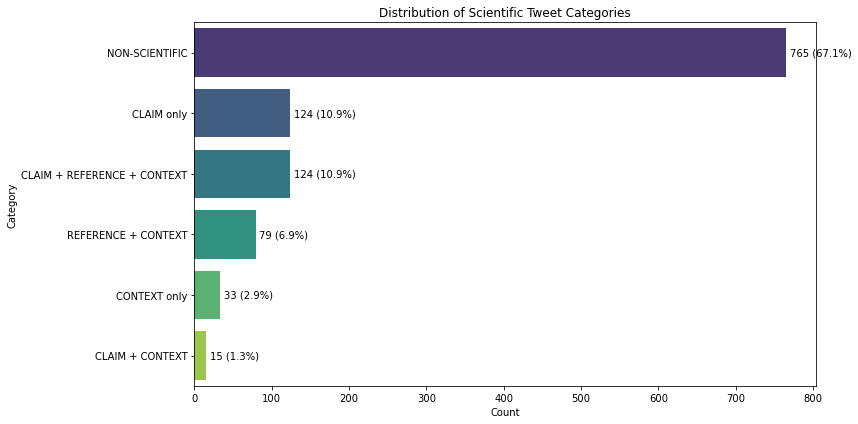

In [163]:
plt.figure(figsize=(12, 6))

ax = sns.countplot(y='label', data=df, order=counts.index, palette='viridis')
for i, count in enumerate(counts.values):
	percentage = (count / len(df)) * 100
	ax.text(count + 5, i, f"{count} ({percentage:.1f}%)", va='center')

plt.title('Distribution of Scientific Tweet Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

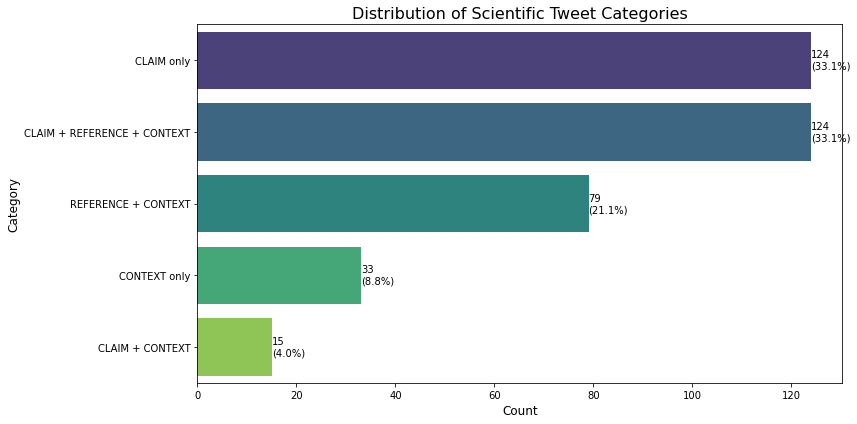

In [164]:
sci_tweets["label_combo"] = sci_tweets[["scientific_claim", "scientific_reference", "scientific_context"]].astype(int).astype(str).agg(" ".join, axis=1)
sci_tweets['label'] = sci_tweets['label_combo'].map(label_mapping)

counts = sci_tweets['label'].value_counts()
plt.figure(figsize=(12, 6))

ax = sns.countplot(y='label', data=sci_tweets, order=counts.index, palette='viridis')
for i, count in enumerate(counts.values):
	
	percentage = (count / len(sci_tweets)) * 100
	ax.text(count, i, f"{count}\n({percentage:.1f}%)", va='center')

plt.title('Distribution of Scientific Tweet Categories', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.tight_layout()
plt.show()

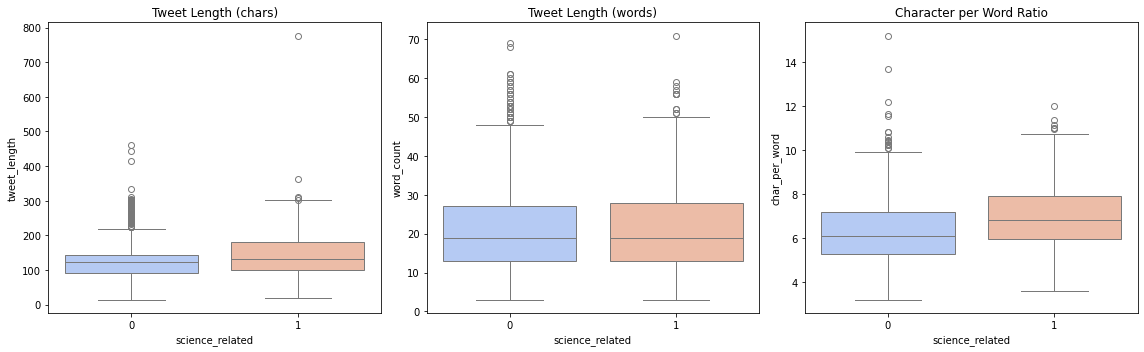

In [165]:
tokenizer = TweetTokenizer()

# Longueur en caractères
df["tweet_length"] = df["text"].apply(len)
# Nombre de mots
df["word_count"] = df["text"].apply(lambda x: len(tokenizer.tokenize(x)))
# Ratio caractères / mots
df["char_per_word"] = df["tweet_length"] / df["word_count"]

yes_tweets = df[df["science_related"] == 1]["tweet_length"]
no_tweets = df[df["science_related"] == 0]["tweet_length"]

plt.figure(figsize=(16, 5))

# 1. Longueur (caractères)
plt.subplot(1, 3, 1)
sns.boxplot(x="science_related", y="tweet_length", data=df, palette="coolwarm")
plt.title("Tweet Length (chars)")

# 2. Nombre de mots
plt.subplot(1, 3, 2)
sns.boxplot(x="science_related", y="word_count", data=df, palette="coolwarm")
plt.title("Tweet Length (words)")

# 3. Ratio char/mot
plt.subplot(1, 3, 3)
sns.boxplot(x="science_related", y="char_per_word", data=df, palette="coolwarm")
plt.title("Character per Word Ratio")

plt.tight_layout()
plt.show()

In [166]:
def count_links(text):
    """Counts the number of URLs in a text."""
    url_pattern = r'https?://\S+|www\.\S+'
    return len(re.findall(url_pattern, str(text)))

df["num_links"] = df["text"].apply(count_links)
df["num_links"].describe()

count    1140.000000
mean        0.789474
std         0.697086
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         5.000000
Name: num_links, dtype: float64

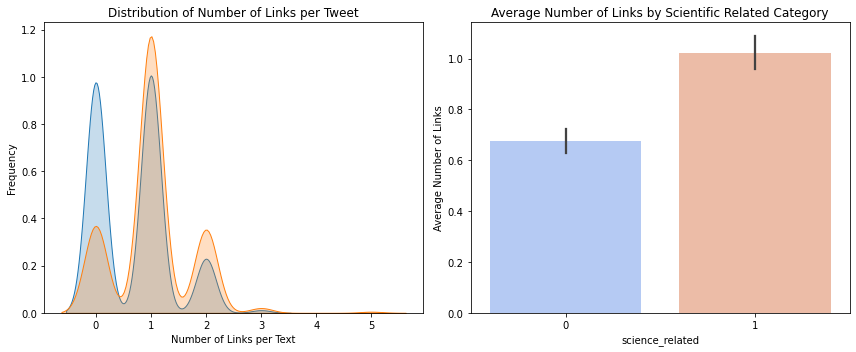

In [167]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#sns.histplot(data=df, x="num_links", bins=10, hue="science_related", multiple="stack", ax=axes[0])
sns.kdeplot(df[df["science_related"] == 0]["num_links"], label="Class 0", shade=True, ax=axes[0])
sns.kdeplot(df[df["science_related"] == 1]["num_links"], label="Class 1", shade=True, ax=axes[0])
axes[0].set_xlabel("Number of Links per Text")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Number of Links per Tweet")


sns.barplot(x="science_related", y="num_links", data=df, palette="coolwarm", ax=axes[1])
axes[1].set_title("Average Number of Links by Scientific Related Category")
axes[1].set_ylabel("Average Number of Links")

plt.tight_layout()
plt.show()


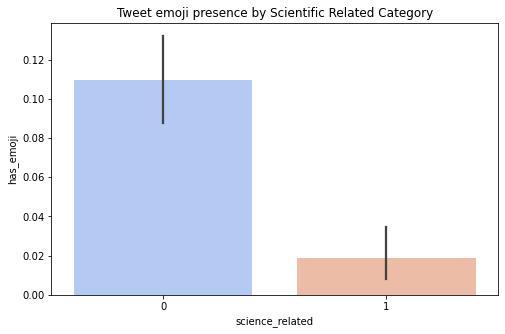

In [168]:
def has_emoji(text):
    """Detects if a text contains at least one emoji."""
    emoji_pattern = re.compile(
        "[\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F700-\U0001F77F"  # Alchemical Symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols, Symbols for legacy computing, etc.
        "\U0001FA70-\U0001FAFF"  # Symbols for legacy computing, other symbols
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed Characters
        "]+", flags=re.UNICODE)

    return bool(re.search(emoji_pattern, str(text)))

df["has_emoji"] = df["text"].apply(has_emoji)

plt.figure(figsize=(8, 5))
sns.barplot(x="science_related", y="has_emoji", data=df, palette="coolwarm")
plt.title("Tweet emoji presence by Scientific Related Category")
plt.show()

Un tweet à 10% de 

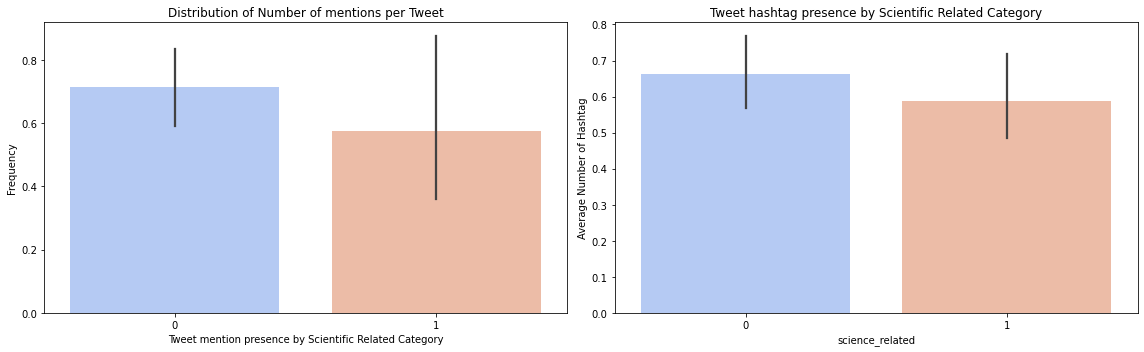

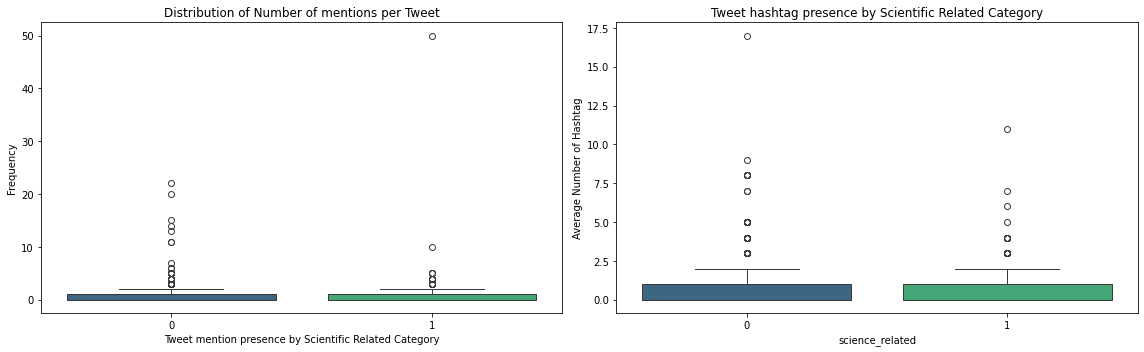

In [174]:
def mentions_number(text):
	"""Compute the number of tags by text ."""
	return len(re.findall(r'@[A-Za-z0-9_]+', text))

def hashtags_number(text):
	"""Compute the number of hashtags in the text."""
	return len(re.findall(r'#[A-Za-z0-9_]+', text))

df["mentions_number"] = df["text"].apply(mentions_number)
df["hashtags_number"] = df["text"].apply(hashtags_number)


plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
sns.barplot(x="science_related", y="mentions_number", data=df, palette="coolwarm")
plt.xlabel("Tweet mention presence by Scientific Related Category")
plt.ylabel("Frequency")
plt.title("Distribution of Number of mentions per Tweet")

plt.subplot(1, 2, 2)
sns.barplot(x="science_related", y="hashtags_number", data=df, palette="coolwarm")
plt.title("Tweet hashtag presence by Scientific Related Category")
plt.ylabel("Average Number of Hashtag")

plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x="science_related", y="mentions_number", data=df, palette="viridis")
plt.xlabel("Tweet mention presence by Scientific Related Category")
plt.ylabel("Frequency")
plt.title("Distribution of Number of mentions per Tweet")

plt.subplot(1, 2, 2)
sns.boxplot(x="science_related", y="hashtags_number", data=df, palette="viridis")
plt.title("Tweet hashtag presence by Scientific Related Category")
plt.ylabel("Average Number of Hashtag")

plt.tight_layout()
plt.show()

In [177]:
def hashtags(text):
	"""Extract hashtags from text."""
	return re.findall(r'#[A-Za-z0-9_]+', text)

sci_hashtags = []
for text in df[df['science_related'] == 1]['text']:
    sci_hashtags.extend(hashtags(text))

nonsci_hashtags = []
for text in df[df['science_related'] == 0]['text']:
    nonsci_hashtags.extend(hashtags(text))

sci_hashtag_counts = Counter(sci_hashtags)
nonsci_hashtag_counts = Counter(nonsci_hashtags)

top_sci_hashtags = sci_hashtag_counts.most_common(10)
top_nonsci_hashtags = nonsci_hashtag_counts.most_common(10)

df["mentions_number"] = df["text"].apply(mentions_number)

<Figure size 1008x720 with 0 Axes>

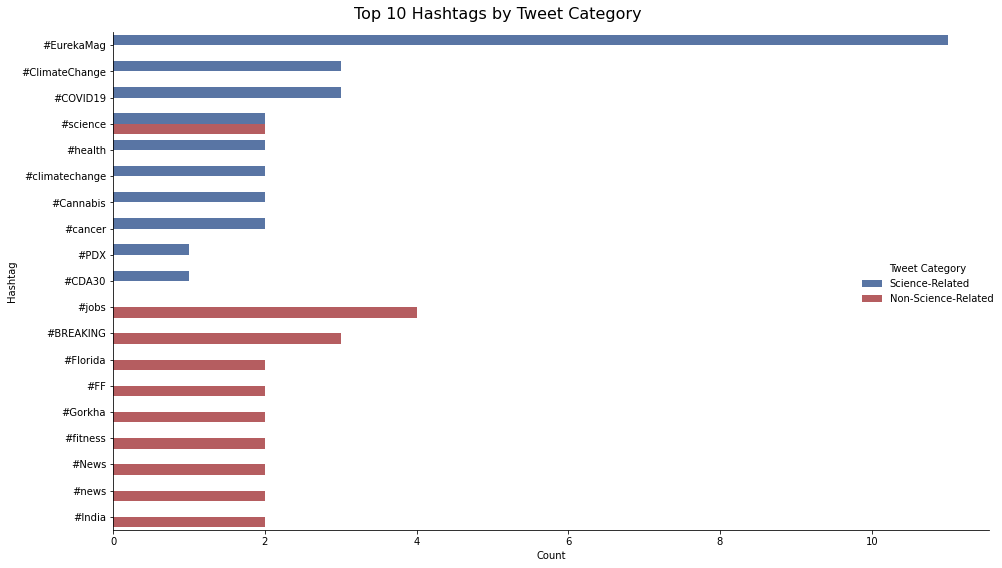

In [179]:
# Create DataFrames for plotting
sci_df = pd.DataFrame(top_sci_hashtags, columns=['Hashtag', 'Count'])
sci_df['Category'] = 'Science-Related'

nonsci_df = pd.DataFrame(top_nonsci_hashtags, columns=['Hashtag', 'Count'])
nonsci_df['Category'] = 'Non-Science-Related'
combined_df = pd.concat([sci_df, nonsci_df])

plt.figure(figsize=(14, 10))
g = sns.catplot(
    data=combined_df, 
    kind="bar",
    x="Count", y="Hashtag", hue="Category",
    palette=["#4C72B0", "#C44E52"],
    height=8, aspect=1.5
)

g.set_axis_labels("Count", "Hashtag")
g.legend.set_title("Tweet Category")
g.fig.suptitle('Top 10 Hashtags by Tweet Category', fontsize=16)
g.fig.subplots_adjust(top=0.9)

plt.tight_layout()
plt.show()